# Face Recognition With Deep Learning

Rico Steinke, 196949, Heilbronn University, rsteinke@stud.hs-heilbronn.de

The project task is to 'create a neural network to recognize your face and clearly discern it from other faces and objects'. Therefore a dataset specifically for this task should be created. Also transfer learning techniques should be used with the restriction that the VGG architecture may not be used. For this purpose, the procedure for creating a data set is shown first. Then, the preprocessing of the data for the use in training a neural network. Finally, the results of the training will be shown and evaluated.
The notebook comes with a file 'condatf.yml' which can be used to create a conda environment that is able to run this notebook. Every cited source is listed in the [Bibliography](#Bibliography) at the end of the notebook. 

### Imports
Import the required packages to execute this jupyter notebook and check if a GPU is available for training.

In [1]:
import glob
import os.path
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import shutil
import seaborn as sns
import ipywidgets as wg
from IPython.display import display
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.1
GPU is available


# Data Preparation

### Creating a dataset
In order to process the task described above, a suitable data set must first be created. For this purpose, the following shows how as many images as possible were obtained by myself. Images from other persons were extended with the help of the LFW database <cite id="o9vrc"><a href="#zotero%7C12668441%2FAN5HZ4B7">(Huang et al., 2007)</a></cite>. Images for the random objects were created by myself and extended using a household objects dataset <cite id="p4fki"><a href="#zotero%7C12668441%2FRVETVPSX">(Meneghetti, 2020)</a></cite>. It also shows how the dataset is created and labeled. Then the data contained in the dataset is visualized. Lastly, they are preprocessed for input to the neural networks being used.


#### Constants
First of all a couple of constants are defined to specify the directories which contain the unprocessed image data. Additionally an image size in pixels is defined to compute the images to this size later on. The chosen size of 224 pixels is the standard input shape for the networks used later on. Also the batch size is defined to control how many samples are used in each epoch. The validation split defines the percentage of the total used data to create the validation dataset. The test split divides the validation dataset to create the test dataset. 

In [2]:
# constants
IMAGES_PATH = "images/"
DATASET_PATH = "dataset/"
DATASET_ME_PATH = DATASET_PATH + "me"
DATASET_SE_PATH = DATASET_PATH + "se"
DATASET_RO_PATH = DATASET_PATH + "ro"
IMAGES_ME_PATH = IMAGES_PATH + "me"
IMAGES_SE_PATH = IMAGES_PATH + "se"
IMAGES_RO_PATH = IMAGES_PATH + "ro"
IMAGES_SE_INPUTPATH = IMAGES_SE_PATH + "/*/*/*"

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 2

To create a dataset to recognize my own face and clearly discern it from other faces it is necessary to get as much pictures of my face as possible. Furthermore different faces are needed. First it is dealt with getting pictures of myself. To achieve this private pictures from my phone and webcam recordings are saved. Secondly OpenCV <cite id="t1hy5"><a href="#zotero%7C12668441%2FEXM36PCP">(Bradski, 2000)</a></cite> is used to detect faces in the pictures. This is especially useful to localize a region of interest if the picture contains multiple faces. The cropped images are getting sorted by hand and saved. This step is already done and does not need to be computed to run this notebook. If you still want to perform this step, it is recommended to use an alternative IDE with an integrated terminal and copy this cell to it to simplify the user input.

In [3]:
# make cell not executable
%%script false

import cv2 as cv

# get images from data path
images = [cv.imread(file) for file in glob.glob(f"{IMAGES_PATH}preDetection/*")]
# convert the images to grayscale
images_gray = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]
# using cascade classifier for general face detection
cascade = cv.CascadeClassifier(r"files\haarcascade_frontalface_default.xml")
# detect faces
faces = [
    cascade.detectMultiScale(img_gray, scaleFactor=1.3, minNeighbors=5, minSize=(100, 100))
    for img_gray in images_gray
]

# loop over images list
j = 0
k = 0
for i, img in enumerate(images):
    for x, y, width, height in faces[i]:
        # crop image at ROI
        crop_image = img[y : y + height, x : x + width]
        # show image for manual validation
        cv.imshow("cropped image", crop_image)
        cv.waitKey(0)
        cv.destroyAllWindows()
        # ask user to sort image
        print(
            "Press 'm' if the picture shows your face. "
            "Press 's' if the picture shows something or somebody else. "
            "Press 'q' if you don't want to save the picture"
        )
        decision = input()
        if decision == "m":
            saved = cv.imwrite(f"{IMAGES_PATH}me/me_{j}.jpg", crop_image)
            if saved:
                print(f"saved to {IMAGES_PATH}me/me_{j}.jpg")
            j += 1
        elif decision == "s":
            saved = cv.imwrite(f"{IMAGES_SE_PATH}/se_{k}.jpg", crop_image)
            if saved:
                print(f"saved to {IMAGES_SE_PATH}/se_{k}.jpg")
            k += 1

UsageError: Line magic function `%%script` not found.


#### Folder structure
The root folder of this project contains the dataset in the *images*-directory and a *preDetection*-directory which contains the private images before labeling them manually as it is described in the step before. The *me*-directory contains images of my face, the *se*-directory contains images of somebody else and the *ro*-directory of random objects. Those are the directories which are used to create the dataset described in the next step.

![/notebookImages/folderStructure.png](notebookImages/folderStructure.png)

The folder structure used in this project work. Use *'tree /f > tree.txt'* in a shell in your root folder to obtain a graphical view of the folder structure.

#### Create Dataset <a id='create_dataset'></a>
To make handling the data easier with tensorflow the *tf.keras.utils.image_dataset_from_directory*-method is used to create a *tf.data.Dataset* from the images in the directories. The creation and visualization of the dataset is done as mentioned in the 'Load and preprocess images'-tutorial of TensorFlow <cite id="3bl27"><a href="#zotero%7C12668441%2FDW3K5WQH">(<i>Load and Preprocess Images | TensorFlow Core</i>, n.d.)</a></cite> and fitted to this use case.

In [6]:
# let user decide if a new dataset should be created
create_new_dataset_cb = wg.Checkbox(value=True, description='Create new dataset')
display(create_new_dataset_cb)

Checkbox(value=True, description='Create new dataset')

In [3]:
# get amount of pictures of se
amount_images_se = sum([len(files) for _, _, files in os.walk(IMAGES_SE_PATH)])
print(f"Total amount of pictures of somebody/something else: {amount_images_se}")
# get max pictures of me
amount_images_me = sum([len(files) for _, _, files in os.walk(IMAGES_ME_PATH)])
print(f"Total amount of pictures of me: {amount_images_me}")
# get max pictures of ro
amount_images_ro = sum([len(files) for _, _, files in os.walk(IMAGES_RO_PATH)])
print(f"Total amount of pictures of ro: {amount_images_ro}")

# let user decide how many images from each class should be used to create the dataset#
print("-------------------------------------------------")
print("Use the sliders to control the amount of images used to create the dataset for each class. (You can use the arrow keys of your keyboard to control the sliders more precisely than with the mouse)")
print("-------------------------------------------------")
se_slider = wg.IntSlider(value=amount_images_se//2, min=0, max=amount_images_se, description="How many images of the class 'se' should be used to create the dataset")
me_slider = wg.IntSlider(value=amount_images_me//2, min=0, max=amount_images_me, description="How many images of the class 'me' should be used to create the dataset")
ro_slider = wg.IntSlider(value=amount_images_ro//2, min=0, max=amount_images_ro, description="How many images of the class 'ro' should be used to create the dataset")

display(se_slider, me_slider, ro_slider)

Total amount of pictures of somebody/something else: 2247
Total amount of pictures of me: 371
Total amount of pictures of ro: 361
-------------------------------------------------
Use the sliders to control the amount of images used to create the dataset for each class. (You can use the arrow keys of your keyboard to control the sliders more precisely than with the mouse)
-------------------------------------------------


IntSlider(value=1123, description="How many images of the class 'se' should be used to create the dataset", ma…

IntSlider(value=185, description="How many images of the class 'me' should be used to create the dataset", max…

IntSlider(value=180, description="How many images of the class 'ro' should be used to create the dataset", max…

In [7]:
amount_images_se_user_input = se_slider.value
amount_images_me_user_input = me_slider.value
amount_images_ro_user_input = ro_slider.value

create_new_dataset = create_new_dataset_cb.value

if create_new_dataset == True:
    print("-------------------------------------------------")
    print(f"Use {amount_images_se_user_input} images of se")
    print(f"Use {amount_images_me_user_input} images of me")
    print(f"Use {amount_images_ro_user_input} images of ro")
    print(f"This makes a total of {amount_images_se_user_input + amount_images_me_user_input + amount_images_ro_user_input} images used.")
    print("-------------------------------------------------")

    # return all path to images in subdirectories from a given root folder
    def load_images_from_folder(rootFolder):
        images = []
        for path, _, files in os.walk(rootFolder):
            for name in files:
                img = os.path.join(path,name)
                if img is not None:
                    images.append(img)
        return images

    image_paths_me = load_images_from_folder(IMAGES_ME_PATH)
    image_paths_se = load_images_from_folder(IMAGES_SE_PATH)
    image_paths_Ro = load_images_from_folder(IMAGES_RO_PATH)

    # shuffle image lists randomly
    random.shuffle(image_paths_me)
    random.shuffle(image_paths_se)
    random.shuffle(image_paths_Ro)

    # limit amount of images used to create dataset
    image_paths_me = image_paths_me[:amount_images_me_user_input]
    image_paths_se = image_paths_se[:amount_images_se_user_input]
    image_paths_Ro = image_paths_Ro[:amount_images_ro_user_input]

    # create dataset directory
    if os.path.exists(DATASET_PATH):
        shutil.rmtree(DATASET_PATH)

    os.makedirs(DATASET_ME_PATH) 
    os.makedirs(DATASET_SE_PATH)
    os.makedirs(DATASET_RO_PATH)
    print(f"Created dataset directory at {DATASET_ME_PATH}, {DATASET_SE_PATH} and {DATASET_RO_PATH}")
    print("-------------------------------------------------")

    # copy random images to dataset directory
    [shutil.copy(image, DATASET_ME_PATH) for image in image_paths_me]
    [shutil.copy(image, DATASET_SE_PATH) for image in image_paths_se]
    [shutil.copy(image, DATASET_RO_PATH) for image in image_paths_Ro]

    # create tf datasets
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=VALIDATION_SPLIT,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
    )

    # determine how many batches are available in validation and test dataset
    validation_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(validation_batches // TEST_SPLIT)
    validation_dataset = validation_dataset.skip(validation_batches // TEST_SPLIT)
    print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
    print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))
else:    
    # create tf datasets
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        labels="inferred",
        validation_split=VALIDATION_SPLIT,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
    )

    # determine how many batches are available in validation and test dataset
    validation_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(validation_batches // TEST_SPLIT)
    validation_dataset = validation_dataset.skip(validation_batches // TEST_SPLIT)
    print("Number of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
    print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))
    print("-------------------------------------------------")
    print("No new dataset was created.")


# print classes for validation of the dataset
class_names = np.array(train_dataset.class_names)
sum_classes = class_names.size
print("-------------------------------------------------")
print(f"The dataset has {sum_classes} classes. Their names are: {class_names}")
print("-------------------------------------------------")


-------------------------------------------------
Use 822 images of se
Use 371 images of me
Use 361 images of ro
This makes a total of 1554 images used.
-------------------------------------------------
Created dataset directory at dataset/me, dataset/se and dataset/ro
-------------------------------------------------
Found 1554 files belonging to 3 classes.
Using 1244 files for training.
Found 1554 files belonging to 3 classes.
Using 310 files for validation.
-------------------------------------------------
The dataset has 3 classes. Their names are: ['me' 'ro' 'se']
-------------------------------------------------
Number of validation batches: 10
Number of test batches: 10


#### Have a look at the data
To get a better visual understanding of the data that is used to in the created dataset the first 9 images of the train dataset with their corresponding labels are plotted. 

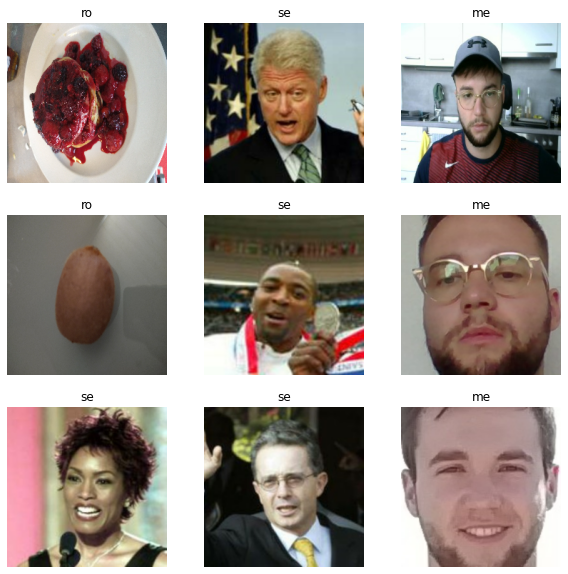

In [8]:
# visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Additionally to the visualization of the actual images above the data distribution of the total available images and the images to used to create the dataset is shown in pie charts below. Furthermore, the relationship between train and validation, respectively validation and test dataset, is shown below.

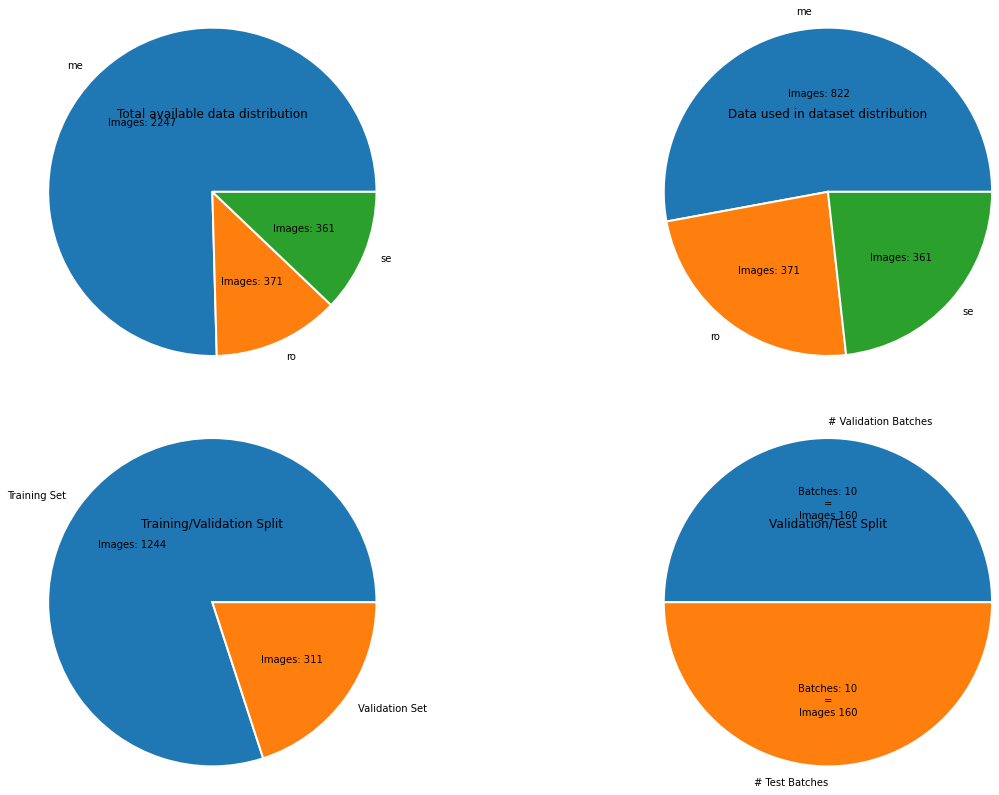

In [9]:
# show data distribution
total_available_data = [amount_images_se, amount_images_me, amount_images_ro] 
data_used_in_dataset = [amount_images_se_user_input, amount_images_me_user_input, amount_images_ro_user_input]
amount_train_images = (amount_images_se_user_input + amount_images_me_user_input + amount_images_ro_user_input) * (1 - VALIDATION_SPLIT) + 1 # files used for trainig gets always rounded up
amount_validation_images = (amount_images_se_user_input + amount_images_me_user_input + amount_images_ro_user_input) * VALIDATION_SPLIT

dataset_distribution = [amount_train_images, amount_validation_images]
dataset_distribution_labels = ["Training Set", "Validation Set"]
test_distribution = [tf.data.experimental.cardinality(validation_dataset), tf.data.experimental.cardinality(test_dataset)]
testDistributionLabels = ["# Validation Batches", "# Test Batches"]

def autopct(values):
    return '{:.0f} / {:,.0f}%'.format(values, values)

fig, axs = plt.subplots(2, 2)

axs[0, 0].pie(total_available_data, labels=class_names, radius=3, wedgeprops={"linewidth": 2, "edgecolor": "white"}, frame=False, autopct=lambda x: 'Images: {:.0f}'.format(x * sum(total_available_data)/100))
axs[0, 1].pie(data_used_in_dataset, labels=class_names, radius=3, wedgeprops={"linewidth": 2, "edgecolor": "white"}, frame=False, autopct=lambda x: 'Images: {:.0f}'.format(x * sum(data_used_in_dataset)/100))
axs[0, 0].set_title("Total available data distribution")
axs[0, 1].set_title("Data used in dataset distribution")
axs[1, 0].pie(dataset_distribution, labels=dataset_distribution_labels, radius=3, wedgeprops={"linewidth": 2, "edgecolor": "white"}, frame=False, autopct=lambda x: 'Images: {:.0f}'.format(x * sum(dataset_distribution)/100))
axs[1, 1].pie(test_distribution, labels=testDistributionLabels, radius=3, wedgeprops={"linewidth": 2, "edgecolor": "white"}, frame=False, autopct=lambda x: 'Batches: {:.0f}\n=\nImages {:.0f}'.format(x * sum(test_distribution)/100, BATCH_SIZE * x * sum(test_distribution)/100))
axs[1, 0].set_title("Training/Validation Split")
axs[1, 1].set_title("Validation/Test Split")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=2, 
                    top=2, 
                    wspace=2, 
                    hspace=2)
plt.show()     

#### Preprocess the data
First of all the dataset is configured for better performance by using the prefetching method. Prefetching overlaps opening, reading and training during the execution of a model. While the training is executed the input pipeline is reading the the data for the next training step. <cite id="qw4im"><a href="#zotero%7C12668441%2FTCJXDMGP">(<i>Better Performance with the Tf.Data API | TensorFlow Core</i>, n.d.)</a></cite> 

To fit the data for putting it into a neural network it needs to be standardized. This means the image size is fixed for the whole dataset. This step is already done in the ['Create Dataset'](#create-dataset)-section. Additionally the pixel values must be normalized from RGB-range (0 - 255) to fit the pixel space the network expects. In this case the range is between -1 and 1. <cite id="mphyw"><a href="#zotero%7C12668441%2FMVDHUU4A">(<i>Transfer Learning and Fine-Tuning | TensorFlow Core</i>, n.d.)</a></cite>

Data augmentation is a technique to increase the diversification of a data set when using a small data set. For this purpose, the training set is transformed randomly but realistically. The data augmentation layer could also be integrated directly into the model, but is already implemented at this point in order to visualize the images in the next step. This creates a better understanding for the applied transformations. <cite id="8yrbo"><a href="#zotero%7C12668441%2FK8WZ388C">(<i>Data Augmentation | TensorFlow Core</i>, n.d.)</a></cite>

In [10]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Rescale the data
preprocess_inputMobileNetV2 = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_inputXception = tf.keras.applications.xception.preprocess_input
rescale = tf.keras.layers.Rescaling(1. / 127.5, offset=-1)

# print batch tensor shape for validation
image_batch, labels_batch = next(iter(train_dataset))
print(f"Shape of batches: {image_batch.shape}")

# apply data augmentation
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Shape of batches: (16, 224, 224, 3)


#### Have a look at the data again
To visualize the effects of the data augmentation an example image is shown after being processed.

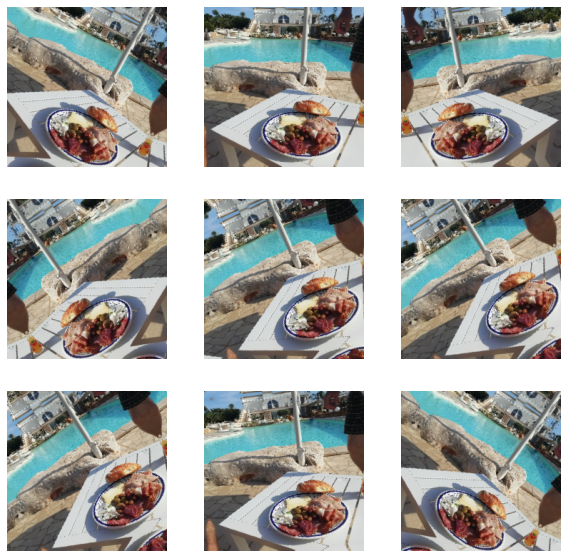

In [9]:
# visualize data augmentation
plt.figure(figsize=(10, 10))
for image, _ in train_dataset.take(1):    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')


# Network Training

### Transfer Learning
A common approach to do image classification tasks with deep neural networks is transfer learning. For transfer learning a pre-trained model is used as the base of the neural network. Then the model is adapted and fine-tuned to work on the specific task. The biggest advantage of transfer learning in image classification is that it can be applied to smaller datasets and the model trains faster. <cite id="j75oy"><a href="#zotero%7C12668441%2FQSWZ8C7A">(Trofimov &#38; Bogatyreva, 2020)</a></cite>

The Keras framework provides a variety of available pre-trained models usable for transfer learning. In the following, two suitable models will be determined and subsequently trained. The results of the training will then be analyzed and discussed. The table below shows the models to choose from. Where the top-1 and top-5 accuracy was determined based on the performance of the model based on the [ImageNet](https://www.image-net.org/index.php) dataset. The value for the depth of the network is composed of the number of activation layers, batch normalization layers etc. Time per inference step is the average of 30 batches and 10 repetitions on the hardware used by Keras and varies on every machine. <cite id="k5b7e"><a href="#zotero%7C12668441%2F3KVIW22P">(Keras Team, n.d.)</a></cite>

| Model             | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | Time (ms) per inference step (CPU) | Time (ms) per inference step (GPU) |
|-------------------|-----------|----------------|----------------|------------|-------|------------------------------------|------------------------------------|
| Xception          | 88        | 79.0%          | 94.5%          | 22.9M      | 81    | 109.4                              | 8.1                                |
| VGG16             | 528       | 71.3%          | 90.1%          | 138.4M     | 16    | 69.5                               | 4.2                                |
| VGG19             | 549       | 71.3%          | 90.0%          | 143.7M     | 19    | 84.8                               | 4.4                                |
| ResNet50          | 98        | 74.9%          | 92.1%          | 25.6M      | 107   | 58.2                               | 4.6                                |
| ResNet50V2        | 98        | 76.0%          | 93.0%          | 25.6M      | 103   | 45.6                               | 4.4                                |
| ResNet101         | 171       | 76.4%          | 92.8%          | 44.7M      | 209   | 89.6                               | 5.2                                |
| ResNet101V2       | 171       | 77.2%          | 93.8%          | 44.7M      | 205   | 72.7                               | 5.4                                |
| ResNet152         | 232       | 76.6%          | 93.1%          | 60.4M      | 311   | 127.4                              | 6.5                                |
| ResNet152V2       | 232       | 78.0%          | 94.2%          | 60.4M      | 307   | 107.5                              | 6.6                                |
| InceptionV3       | 92        | 77.9%          | 93.7%          | 23.9M      | 189   | 42.2                               | 6.9                                |
| InceptionResNetV2 | 215       | 80.3%          | 95.3%          | 55.9M      | 449   | 130.2                              | 10.0                               |
| MobileNet         | 16        | 70.4%          | 89.5%          | 4.3M       | 55    | 22.6                               | 3.4                                |
| MobileNetV2       | 14        | 71.3%          | 90.1%          | 3.5M       | 105   | 25.9                               | 3.8                                |
| DenseNet121       | 33        | 75.0%          | 92.3%          | 8.1M       | 242   | 77.1                               | 5.4                                |
| DenseNet169       | 57        | 76.2%          | 93.2%          | 14.3M      | 338   | 96.4                               | 6.3                                |
| DenseNet201       | 80        | 77.3%          | 93.6%          | 20.2M      | 402   | 127.2                              | 6.7                                |
| NASNetMobile      | 23        | 74.4%          | 91.9%          | 5.3M       | 389   | 27.0                               | 6.7                                |
| NASNetLarge       | 343       | 82.5%          | 96.0%          | 88.9M      | 533   | 344.5                              | 20.0                               |
| EfficientNetB0    | 29        | 77.1%          | 93.3%          | 5.3M       | 132   | 46.0                               | 4.9                                |
| EfficientNetB1    | 31        | 79.1%          | 94.4%          | 7.9M       | 186   | 60.2                               | 5.6                                |
| EfficientNetB2    | 36        | 80.1%          | 94.9%          | 9.2M       | 186   | 80.8                               | 6.5                                |
| EfficientNetB3    | 48        | 81.6%          | 95.7%          | 12.3M      | 210   | 140.0                              | 8.8                                |
| EfficientNetB4    | 75        | 82.9%          | 96.4%          | 19.5M      | 258   | 308.3                              | 15.1                               |
| EfficientNetB5    | 118       | 83.6%          | 96.7%          | 30.6M      | 312   | 579.2                              | 25.3                               |
| EfficientNetB6    | 166       | 84.0%          | 96.8%          | 43.3M      | 360   | 958.1                              | 40.4                               |
| EfficientNetB7    | 256       | 84.3%          | 97.0%          | 66.7M      | 438   | 1578.9                             | 61.6                               |
| EfficientNetV2B0  | 29        | 78.7%          | 94.3%          | 7.2M       | -     | -                                  | -                                  |
| EfficientNetV2B1  | 34        | 79.8%          | 95.0%          | 8.2M       | -     | -                                  | -                                  |
| EfficientNetV2B2  | 42        | 80.5%          | 95.1%          | 10.2M      | -     | -                                  | -                                  |
| EfficientNetV2B3  | 59        | 82.0%          | 95.8%          | 14.5M      | -     | -                                  | -                                  |
| EfficientNetV2S   | 88        | 83.9%          | 96.7%          | 21.6M      | -     | -                                  | -                                  |
| EfficientNetV2M   | 220       | 85.3%          | 97.4%          | 54.4M      | -     | -                                  | -                                  |
| EfficientNetV2L   | 479       | 85.7%          | 97.5%          | 119.0M     | -     | -                                  | -                                  |

<div align="center">Table: Models available in Keras. <cite id="hgvpe"><a href="#zotero%7C12668441%2F3KVIW22P">(Keras Team, n.d.)</a></cite>

The table shows that the time required for an inference step is directly related to the number of parameters and the depth of the network. In order to find the right network for the respective application, the available hardware should be taken into account and, depending on the hardware, networks with few parameters or less depth should be used for faster training. 

Accuracy should also be taken into account. A distinction should be made between top-1 and top-5 accuracy. The top-1 accuracy is that the prediction of the model is exactly the expected answer. Top-5 accuracy means that the model determines the correct answer among the 5 highest probabilities of the network prediction. <cite id="yyeur"><a href="#zotero%7C12668441%2FHSDR2DAU">(Dang, 2021)</a></cite> 

Since a strong graphics card, the [Nvidia GeForce RTX 3070](https://www.nvidia.com/de-de/geforce/graphics-cards/30-series/rtx-3070-3070ti/), is available for training, a computationally more intensive model will be trained. In addition, the model should have a high top-1 accuracy, since it should distinguish exactly between my face and other faces or objects. For comparison, a model with lower hardware requirements is trained. The choice fell on the Xception <cite id="m55tv"><a href="#zotero%7C12668441%2F55VIEFNV">(Chollet, 2017)</a></cite> and the MobileNetV2 <cite id="fmocb"><a href="#zotero%7C12668441%2FTECZ9G6S">(Sandler et al., 2019)</a></cite> as the less power-requiring alternative.

#### Transfer learning workflow
A common transfer learning approach is to freeze the layers of the pre-trained model. That means the weights of the base model won't be updated to avoid trainig the model from scratch. Next there are new layers added on top of the frozen layers which are trainable. These layers are necessary to turn the features of the pre-trained model into predictions of the new dataset. Then the model is trained. Optionally the model can be fine-tuned by making all the layers trainable and and adapting them to the new data. <cite id="7g9jb"><a href="#zotero%7C12668441%2FMVDHUU4A">(<i>Transfer Learning and Fine-Tuning | TensorFlow Core</i>, n.d.)</a></cite> This transfer learning workflow is shown for both base models below.

#### Determine hyperparameters
Hyperparameters are variables that define the structure of the network and how it is trained. Therefore, they are set before training. 

In terms of network structure, the number of hidden layers and their activation functions and dimension of the output space must be defined. Since the base model already defines layers when using transfer learning, the input layer and the output layer must first be adapted for the data set used. Further hidden layers are optional and can improve the performance of the model. In addition, dropout layers can be used for regularization to avoid overfitting when using small datasets with large models. This is achieved by ignoring a number of neurons of the respective layer during training based on the dropout rate. Which neurons are ignored is random. This prevents situations where layers become dependent on each other, which leads to overfitting. <cite id="lbp6i"><a href="#zotero%7C12668441%2FKBZ893NQ">(Radhakrishnan, 2017)</a></cite> <cite id="y4ost"><a href="#zotero%7C12668441%2F2JRFCD29">(Brownlee, 2018)</a></cite>

In terms of training the model the learning rate and optimizer must be defined to define how fast the neural network updates its weights. The number of epochs defines how often the entire training dataset is fed into the neural network. The batch size defines the number of images that are fed into the network before a parameter update takes place. <cite id="6dbol"><a href="#zotero%7C12668441%2FKBZ893NQ">(Radhakrishnan, 2017)</a></cite>

To set appropriate hyperparameters for both models, the keras tuner is used. The framework provides functions to define ranges for different hyperparameters. An algorithm then tests different combinations of hyperparameters to find the best possible ones for the model.
First the base model is initialized. The 'choice' function is used to define that the algorithm makes a choice whether, for example, additional dropout or dense layers improve performance or which learning rate is beneficial. <cite id="n69wi"><a href="#zotero%7C12668441%2FVNN8RVKS">(O’Malley, Tom and Bursztein, Elie and Long, James and Chollet, Francois and Jin, Haifeng and Invernizzi, Luca and others, 2019)</a></cite> The keras tuner workflow is implemented as in <cite id="bc51l"><a href="#zotero%7C12668441%2FHNNEIQHR">(<i>Introduction to the Keras Tuner | TensorFlow Core</i>, n.d.)</a></cite> but adapted to the use case in this notebook.

It should also be noted that the keras tuner is able to output a complete model that can be trained immediately. However, this is not used here, but the results of the hyperparameter tuning are added manually to the base model. This procedure is chosen to better describe the transfer learning in the following. Furthermore the hyperparameter tuning is not running every possible hyperparameter configuration composition. This means that by testing the hyperparameter composition can be further improved. The result of the hyperparameter tuning should rather be considered as a first orientation for the final definition of the hyperparameters.


In [10]:
# let user decide if and for which model the hyperparameters will be tuned
hyperparam_tuner_select = wg.Select(
    options=['None', 'Xception', 'MobileNetV2'],
    value='None',
    description='Choose if you want to tune the hyperparameters of a model.'
)

# let user decide if a new hyperparameter tuning should be started
delete_old_tuner_checkpoints_cb = wg.Checkbox(value=False, description='Delete old tuner checkpoints - Start hyperparameter tuning from scratch')

display(delete_old_tuner_checkpoints_cb, hyperparam_tuner_select)

Checkbox(value=False, description='Delete old tuner checkpoints - Start hyperparameter tuning from scratch')

Select(description='Choose if you want to tune the hyperparameters of a model.', options=('None', 'Xception', …

In [29]:
tuner_dir = 'hyperparam_tuner'

if hyperparam_tuner_select.value == 'Xception':
    baseModel_name='xception'
elif hyperparam_tuner_select.value == 'MobileNetV2':
    baseModel_name='mobileNetV2'

tuner_model_dir = f"{tuner_dir}/{baseModel_name}"

# delete old tuner checkpoints
if delete_old_tuner_checkpoints_cb.value == True and os.path.exists(tuner_model_dir):
        shutil.rmtree(tuner_model_dir)
        print(f"Removed directory {tuner_model_dir}")

Removed directory hyperparam_tuner/xception


In [30]:
def model_builder(hp):
  if hyperparam_tuner_select.value == 'None':
    return 
  elif hyperparam_tuner_select.value == 'Xception':
    base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
  elif hyperparam_tuner_select.value == 'MobileNetV2':
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  # freeze the convolutional base
  base_model.trainable = False
  # apply preprocessing layers
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = inputs
  if hyperparam_tuner_select.value == 'Xception':
        x = preprocess_inputXception(x)        
        x = rescale(x)
  elif hyperparam_tuner_select.value == 'MobileNetV2':
        x = preprocess_inputMobileNetV2(x)
    
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  # let tuner decide which global pooling method is used
  if hp.Choice('global_pooling', ['max', 'avg']) == 'max':
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
  else:
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
  # let tuner decide to add an additional dropout layer    
  add_dropout = hp.Choice('additional_dropout_choice_1', [0, 1])
  if add_dropout == 1:   
    x = tf.keras.layers.Dropout(hp.Float("additional_dropout_layer_1", min_value=0.1, max_value=0.6, step=0.1))(x)

  # let tuner decide if an an additional dense layer is benefical
  add_dense = hp.Choice('additional_dense_choice_1', [0, 1])
  if add_dense == 1:  
    hp_units = hp.Int('units', min_value=16, max_value=256, step=32)
    hp_activation = hp.Choice('activation', ['relu', 'swish', 'leakyrelu'])
    if hp_activation == 'leakyrelu':
      hp_activation = tf.keras.layers.LeakyReLU()
    x = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(x)
  # let tuner decide again to add an additional dropout layer    
  add_dropout = hp.Choice('additional_dropout_choice_2', [0, 1])
  if add_dropout == 1: 
    x = tf.keras.layers.Dropout(hp.Float("additional_dropout_layer_2", min_value=0.1, max_value=0.6, step=0.1))(x)
  # output layer is predefined and should not be changed by the tuner
  outputs = tf.keras.layers.Dense(sum_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
  # Find the optimal optimizer
  hp_optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'adamax', 'adadelta', 'nadam'])

  # Choice-method doesnot allow tf optimizer objects
  # to assign a learning rate to the optimizer in the 
  # compile-method the tf optimizier object is needed:
  if hp_optimizer == 'adam':
    hp_optimizer = tf.keras.optimizers.Adam
  elif hp_optimizer == 'sgd':
    hp_optimizer = tf.keras.optimizers.SGD
  elif hp_optimizer == 'adamax':
    hp_optimizer = tf.keras.optimizers.Adamax
  elif hp_optimizer == 'adadelta':
    hp_optimizer = tf.keras.optimizers.Adadelta
  elif hp_optimizer == 'nadam':
    hp_optimizer = tf.keras.optimizers.Nadam
  model.compile(optimizer=hp_optimizer(hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

The algorithm used to find the best hyperparameters is the Hyperband-algorithm. Which basically creates randomly sampled configurations. <cite id="ezfxb"><a href="#zotero%7C12668441%2FP3H3DSD7">(Li et al., 2018)</a></cite>

In [31]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=tuner_dir,
                     project_name=baseModel_name)

Print a summary of the search space to visualize which hyperparameters are getting tuned.

In [32]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
global_pooling (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
additional_dropout_choice_1 (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
additional_dense_choice_1 (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
additional_dropout_choice_2 (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'adamax', 'adadelta', 'nadam'], 'ordered': False}


Define a callback to stop the hyperparameter tuning for a random configuration early. Callbacks are described in more detail in the [Callbacks](#callbacks)-section.

In [33]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Start the search for the best hyperparameter configuration and print the results.

In [34]:
tuner.search(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[stop_early])
tuner.results_summary()

Trial 30 Complete [00h 00m 35s]
val_accuracy: 0.6666666865348816

Best val_accuracy So Far: 0.8238993883132935
Total elapsed time: 00h 08m 03s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in hyperparam_tuner\xception
Showing 10 best trials
Trial summary
Hyperparameters:
global_pooling: avg
additional_dropout_choice_1: 1
additional_dense_choice_1: 0
additional_dropout_choice_2: 0
learning_rate: 0.001
optimizer: adam
additional_dropout_layer_2: 0.30000000000000004
units: 208
activation: relu
additional_dropout_layer_1: 0.4
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.8238993883132935
Trial summary
Hyperparameters:
global_pooling: avg
additional_dropout_choice_1: 1
additional_dense_choice_1: 0
additional_dropout_choice_2: 0
learning_rate: 0.001
optimizer: adamax
additional_dropout_layer_2: 0.30000000000000004
units: 144
activation: leakyrelu
additional_dropout_layer_1: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tun

In the next step the base models are getting instantiated and frozen as described above. Afterwards the input layer is defined. This layer needs to have the shape of images in the dataset and has no trainable parameters. Then the data augmentation and preprocessing layers are added. Next the results of the hyperparameter tuning are applied. As the final layer the output layer is defined. Because the task is a multiclassifaciton problem the activation used in the output layer is the softmax function and the loss function is the sparse categorical crossentropy. The sparse categorical crossentropy is also used because the labels are not provided in a one-hot encoded representation. The number of epochs can be set high, as the use of an early stop callback allows the training to be stopped earlier if necessary (see also [Callbacks](#callbacks)).  

In [24]:
# define some hyperparameters
initial_epochs = 50
base_learningRate = 0.001

# Create the base model from the pre-trained model MobileNet V2
print(f"Image shape: {IMG_SHAPE}")
base_model_mobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

# freeze the convolutional base
base_model_mobileNetV2.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_inputMobileNetV2(x)
x = base_model_mobileNetV2(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dense(units=208, activation='swish')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
outputs = tf.keras.layers.Dense(sum_classes, activation='softmax')(x)
mobileNetV2_model = tf.keras.Model(inputs, outputs)

mobileNetV2_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learningRate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mobileNetV2_model.summary()

Image shape: (224, 224, 3)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                

In [49]:
# define some hyperparameters
initial_epochs = 50
base_learningRate = 0.001

# Create the base model from the pre-trained model Xception
base_model_xception = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

# freeze the convolutional base
base_model_xception.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_inputXception(x)
x = rescale(x)
x = base_model_xception(x, training=False)
#x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=144, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
outputs = tf.keras.layers.Dense(sum_classes, activation='softmax')(x)
xception_model = tf.keras.Model(inputs, outputs)

xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learningRate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

xception_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        2086

### Callbacks
Callbacks are called at different points during the trainig process. The can be used to implement validation behaviors, thresholds for losses and accuracies or even fine-tuning of hyperparameters and layers.

For this notebook an early stopping callback is used. When training is no longer improving the validation loss metrics the callback is terminating the training. The training loop will check after every third (defined by the *patience*-parameter) epoch wether the validation loss is still decreasing. The *min-delta*-parameter sets the minimum change of the monitored metric which qualifies as a decreasing loss. <cite id="75bkj"><a href="#zotero%7C12668441%2FV3N9ZZVF">(<i>Tf.Keras.Callbacks.EarlyStopping | TensorFlow Core v2.9.1</i>, n.d.)</a></cite> Besides the obvious that this can make the training process less time consuming, this technique can be used to prevent overfitting. This is because usually the training causes the validation loss to decrease as the network weights improve. If you exceed a certain number of epochs during training, the training error will continue to decrease but the validation loss may increase. This would be overfitting.

Additionally model checkpoint callbacks are initialized for both models. The callback saves the weights periodically after each epoch if the monitored validation accuracy is higher than the one saved so far. The saved weights can be used later if you want to use a model without training it again or if you want to continue the training process at a later time. <cite id="vxsch"><a href="#zotero%7C12668441%2FSTTH88WB">(<i>Save and Load Models | TensorFlow Core</i>, n.d.)</a></cite> 

In [13]:
checkpoint_filepath_xception = "checkpoints/xception"
checkpoint_filepath_mobileNetV2 = "checkpoints/mobileNetV2"

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=1e-3
)

xception_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_xception,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

mobileNetV2_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mobileNetV2,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Training the models
The actual training of the models is started. The user can decide beforehand if he prefers to use the weights stored by a callback.

In [26]:
# let user decide if weights should be loaded
load_weights_mobileNetV2_cb = wg.Checkbox(value=False, description='Load weights for MobileNetV2.')

display(load_weights_mobileNetV2_cb)

Checkbox(value=False, description='Load weights for MobileNetV2.')

In [27]:
if not load_weights_mobileNetV2_cb.value:
    mobileNetV2_history = mobileNetV2_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks= [mobileNetV2_callback, early_stop_callback])
else:
    mobileNetV2_model.load_weights(checkpoint_filepath_mobileNetV2)

Epoch 1/50
78/78 [==============================] - 4s 33ms/step - loss: 1.0235 - accuracy: 0.8280 - val_loss: 0.1854 - val_accuracy: 0.9333
Epoch 2/50
78/78 [==============================] - 2s 23ms/step - loss: 0.1696 - accuracy: 0.9542 - val_loss: 0.0812 - val_accuracy: 0.9600
Epoch 3/50
78/78 [==============================] - 2s 21ms/step - loss: 0.1225 - accuracy: 0.9590 - val_loss: 0.1316 - val_accuracy: 0.9600
Epoch 4/50
78/78 [==============================] - 2s 22ms/step - loss: 0.1125 - accuracy: 0.9574 - val_loss: 0.1839 - val_accuracy: 0.9400
Epoch 5/50
78/78 [==============================] - 2s 22ms/step - loss: 0.1152 - accuracy: 0.9630 - val_loss: 0.0750 - val_accuracy: 0.9667
Epoch 6/50
78/78 [==============================] - 2s 23ms/step - loss: 0.0862 - accuracy: 0.9703 - val_loss: 0.0426 - val_accuracy: 0.9867
Epoch 7/50
78/78 [==============================] - 2s 22ms/step - loss: 0.0571 - accuracy: 0.9799 - val_loss: 0.0581 - val_accuracy: 0.9800
Epoch 8/50
78

In [14]:
# let user decide if weights should be loaded
load_weights_xception_cb = wg.Checkbox(value=False, description='Load weights for Xception.')

display(load_weights_xception_cb)

Checkbox(value=False, description='Load weights for Xception.')

In [50]:
if not load_weights_xception_cb.value:
    xception_history = xception_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks= [xception_callback, early_stop_callback])
else:
    xception_model.load_weights(checkpoint_filepath_xception)

Epoch 1/50
78/78 [==============================] - 5s 47ms/step - loss: 0.9682 - accuracy: 0.5305 - val_loss: 0.8529 - val_accuracy: 0.5733
Epoch 2/50
78/78 [==============================] - 3s 41ms/step - loss: 0.8428 - accuracy: 0.6061 - val_loss: 0.7535 - val_accuracy: 0.7000
Epoch 3/50
78/78 [==============================] - 3s 41ms/step - loss: 0.7375 - accuracy: 0.7050 - val_loss: 0.6791 - val_accuracy: 0.7133
Epoch 4/50
78/78 [==============================] - 3s 41ms/step - loss: 0.6654 - accuracy: 0.7307 - val_loss: 0.6279 - val_accuracy: 0.7200
Epoch 5/50
78/78 [==============================] - 3s 41ms/step - loss: 0.6028 - accuracy: 0.7677 - val_loss: 0.5911 - val_accuracy: 0.7333
Epoch 6/50
78/78 [==============================] - 3s 41ms/step - loss: 0.5769 - accuracy: 0.7757 - val_loss: 0.5516 - val_accuracy: 0.7733
Epoch 7/50
78/78 [==============================] - 3s 41ms/step - loss: 0.5397 - accuracy: 0.7878 - val_loss: 0.5361 - val_accuracy: 0.7667
Epoch 8/50
78

### Fine-tuning
Fine-tuning can provide additional improvement when applying transfer learning. Once the model has converged with the new data, all layers of the base model can be made trainable. The entire model is then trained with a very small learning rate. The small learning rate is crucial to avoid overfitting, since you are now training a much larger model with a rather small dataset. If you allow large changes in the weights with a larger learning rate, this can lead to overfitting. <cite id="lk8ma"><a href="#zotero%7C12668441%2FMVDHUU4A">(<i>Transfer Learning and Fine-Tuning | TensorFlow Core</i>, n.d.)</a></cite> 

In [51]:
# unfreeze the base model
base_model_xception.trainable = True

xception_model.summary()

xception_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 10
fineTuned_xcpetion_history = xception_model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[xception_callback, early_stop_callback])


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        2086

In [28]:
# unfreeze the base model
base_model_mobileNetV2.trainable = True

mobileNetV2_model.summary()

mobileNetV2_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 10
fineTuned_mobileNetV2_history = mobileNetV2_model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[mobileNetV2_callback, early_stop_callback])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

# Evaluation

After the network training is finished a visual representation of the network performance is desired. Therefore a method is introduced that plots the training and validation losses and respective accuracies for a given trainig history. Additionally the method shows the start of the fine-tuning process. 

The plots are useful to examine the network for over- and underfitting behavior. If the two curves approximately coincide, the model is neither over- nor underfitting. If the training accuracy is larger than the validation accuracy and the training loss is smaller than the validation loss, the network tends to overfitting. If the training accuracy is smaller than the validation accuracy and the training loss is larger than the validation loss, the network tends to underfitting.

In [29]:
def plot_history(model_history, title, fineTuning_history):
    # get amount of epochs the training ran before fine-tuning
    fineTuning_start = len(model_history.history['loss']) - 1
    # Basic plot configuration
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('Training history: ' + title, fontsize=16, y=1.01, fontweight='bold')
    # Loss
    plt.subplot(121)    
    plt.plot(model_history.history['loss'] + fineTuning_history.history['loss'], label='train loss')
    plt.plot(model_history.history['val_loss'] + fineTuning_history.history['val_loss'], label='val loss')
    plt.axvline(x=fineTuning_start, color='g', label='Fine-tuning start')
    plt.ylim(0,1.0)
    plt.legend()
    # Accuracies
    plt.subplot(122)
    plt.plot(model_history.history['accuracy'] + fineTuning_history.history['accuracy'], label='train accuracy')
    plt.plot(model_history.history['val_accuracy'] + fineTuning_history.history['val_accuracy'], label='val accuracy')
    plt.axvline(x=fineTuning_start, color='g', label='Fine-tuning start')
    plt.ylim(0,1.15)
    plt.legend()
    plt.show()

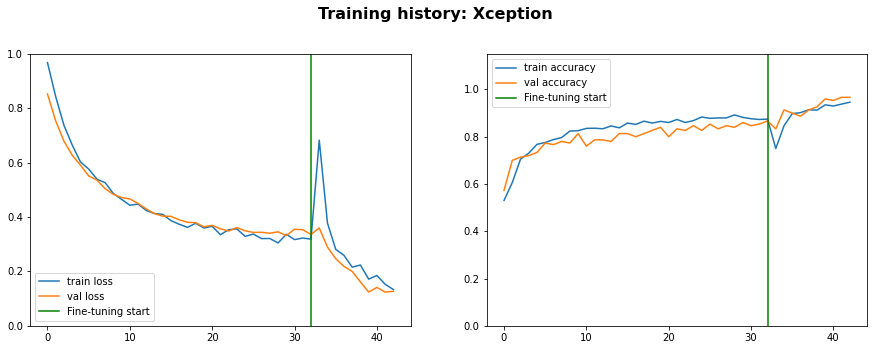

In [52]:
# Plot the training history: Xception
plot_history(xception_history, 'Xception', fineTuned_xcpetion_history)

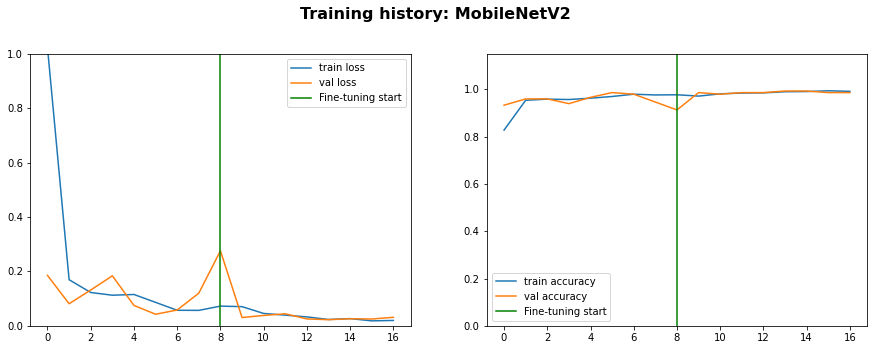

In [30]:
# Plot the training history: MobileNetV2
plot_history(mobileNetV2_history, 'MobileNetV2', fineTuned_mobileNetV2_history)

# Evaluation
To evaluate the performance of the previously trained neural networks, the networks are exposed to the previously unseen test dataset. To visualize the performance confusion matrices are ploted. In addition, a function is implemented to calculate the loss and accuracy for both networks.

## Confusion matrices
Confusion matrices are a way to visualize the performance of classification problems in deep learning. They display the prediction of the neural network and the correct label of the respective input image. This is especially useful to identify classes that are prone to misclassifications. Besides the confusion matrices the misclassified images are ploted.

In the code below a function is implemented which expects the respective model and dataset as inputs. This makes it handy to plot the confusion matrix for both models used.

In [42]:
def make_predictions(model, dataset):
    predictions = []
    targets = []
    images = []
    for image_batch, label_batch in dataset:
        images.append(image_batch) 
        targets.append(label_batch)
        pred = model.predict(image_batch)
        predictions.append(np.argmax(pred, axis= -1))

    true_labels = tf.concat([item for item in targets], axis=0)
    pred_labels = tf.concat([item for item in predictions], axis=0)
    images = tf.concat([item for item in images], axis=0)
    return pred_labels, true_labels, images

# Generate a confusion matrix for a defined model and dataset
def get_confusion_matrix(true_labels, pred_labels):
    print("Generating confusion matrix...")    
    cm = tf.math.confusion_matrix(true_labels, pred_labels)
    return cm

# Plot a tensorflow confusion matrix using seaborn heatmap
def show_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('True Label')
    plt.show()

# Plot mispredictions
def show_mispredictions(predictions_labels, true_labels, test_images):
    # convert tensor to numpy array
    predictions_labels = predictions_labels.numpy()
    true_labels = true_labels.numpy()
    mispredictions = []
    # finde mispredicted images
    for i in range(len(test_images)):
        if true_labels[i] != predictions_labels[i]:
            mispredictions.append([test_images[i], true_labels[i], predictions_labels[i]])

    # plot mispredicted images      
    plt.figure(figsize=(10, 10))
    # print only 9 mispredictions max
    if len(mispredictions) > 9:
        mispredictions = mispredictions[:9] 
    for i in range(len(mispredictions)):    
        plt.subplot(3, 3, i + 1)
        plt.imshow(mispredictions[i][0].numpy().astype("uint8"))
        true_label = mispredictions[i][1]    
        predicted_label = mispredictions[i][2]
        plt.title(f"True label: {class_names[true_label]}\nPredicted Label: {class_names[predicted_label]}")
        plt.axis('off')
    print(f"Total mispredictions: {len(mispredictions)}")

In [33]:
# Get amount of images used for testing
test_dataset_files = len(np.concatenate([i for _, i in test_dataset], axis=0))
print(f"Sum of images used for testing: {test_dataset_files}")

Sum of images used for testing: 160


1/1 [==============================] - 0s 15ms/step
Generating confusion matrix...


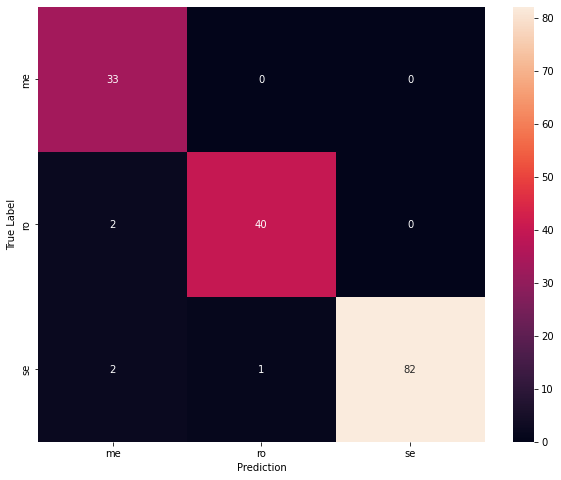

In [55]:
# Plot confusion matrix for Xception
if load_weights_xception_cb.value:
    xception_model.load_weights(checkpoint_filepath_xception)

predictions_labels_xception, true_labels_xception, test_images_xception = make_predictions(xception_model, test_dataset) 
xception_confusion_matrix = get_confusion_matrix(true_labels_xception, predictions_labels_xception)
show_confusion_matrix(xception_confusion_matrix)

Total mispredictions: 5


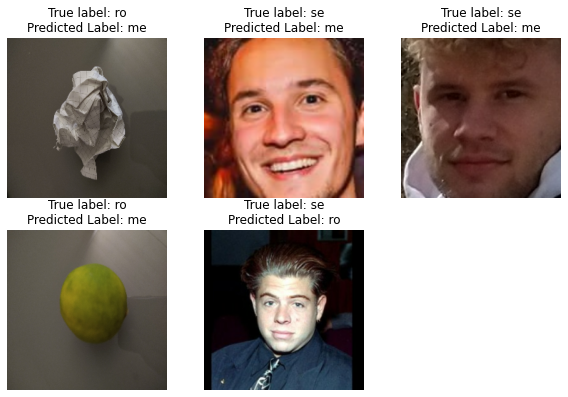

In [56]:
# show mispredicted images xception
show_mispredictions(predictions_labels_xception, true_labels_xception, test_images_xception)

1/1 [==============================] - 0s 15ms/step
Generating confusion matrix...


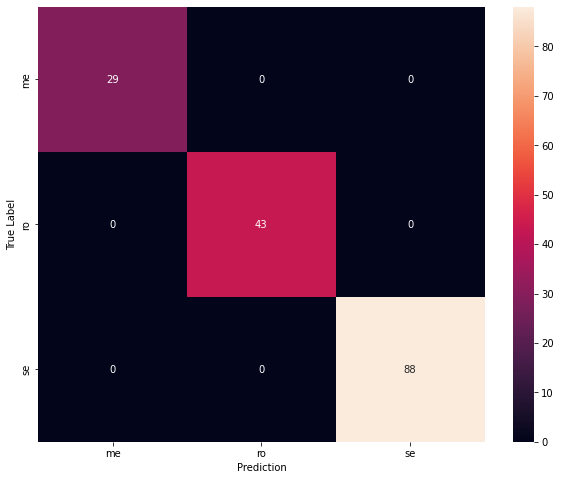

In [36]:
# Plot confusion matrix for MobileNetV2
if load_weights_mobileNetV2_cb.value:
    mobileNetV2_model.load_weights(checkpoint_filepath_mobileNetV2)
    
predictions_labels_mobileNetV2, true_labels_mobileNetV2, test_images_mobileNetV2 = make_predictions(mobileNetV2_model, test_dataset) 
mobileNetV2_confusion_matrix = get_confusion_matrix(true_labels_mobileNetV2, predictions_labels_mobileNetV2)
show_confusion_matrix(mobileNetV2_confusion_matrix)

In [37]:
# Show mispredicted images MobileNetV2
show_mispredictions(predictions_labels_mobileNetV2, true_labels_mobileNetV2, test_images_mobileNetV2)

Total mispredictions: 0


<Figure size 720x720 with 0 Axes>

## Model Testing

In [57]:
# Evaluate a model with the test dataset and print testing loss and testing accuracy
def model_testing(model, test_dataset):
    loss, acc = model.evaluate(test_dataset)
    print("-------------------------------------------------")
    print(f"Testing loss: {loss}")
    print(f"Testing accuracy: {acc}")
    print("-------------------------------------------------")

In [58]:
print("Testing MobileNetV2")
model_testing(mobileNetV2_model, test_dataset)
print("Testing Xception")
model_testing(xception_model, test_dataset)

Testing MobileNetV2
10/10 [==============================] - 1s 42ms/step - loss: 0.0056 - accuracy: 1.0000
-------------------------------------------------
Testing loss: 0.005572275258600712
Testing accuracy: 1.0
-------------------------------------------------
Testing Xception
10/10 [==============================] - 1s 42ms/step - loss: 0.1443 - accuracy: 0.9688
-------------------------------------------------
Testing loss: 0.1443128138780594
Testing accuracy: 0.96875
-------------------------------------------------


# Discussion of the results
The MobileNetV2 shows outstanding results in the classification of images. The network already converges after a few epochs and the curves are fitting except for small outliers. From epoch six, it should be noted that the network starts to overfit. This can be seen from the fact that the validation loss increases and the train loss remains low. The accuracy plots also illustrate this, since the validation accuracy decreases from epoch six and is thus smaller than the train accuracy. Both are clear indications of overfitting. Correctly, the training is aborted at this point due to the implementation of the callback. The plot also shows that fine-tuning still brings a few percentage points of improvement. Overfitting caused by fine-tuning cannot be detected. The result is a perfect diagonal confusion matrix. The results described before are shown in the pictures below.

![MobileNetV2 History](notebookImages/mobilenet_history_paramtuned.png) ![MobileNetV2 Confusion Matrix](notebookImages/mobilenet_cm_paramtuned.png)

In numbers, the MobileNetV2 achieves a testing accuracy of 100% with a minimum testing loss of 0.5%. Due to the good results, the model was trained only with the hyperparameter suggestions of the tuner. The variable hyperparameters used are shown in the table below.

| Hyperparameter             | Value                                 |
|----------------------------|---------------------------------------|
| Global Pooling Method      | Max Pooling                           |
| Additional Dropout Layer 1 | Used, Dropout Rate = 0.1              |
| Additional Dense Layer     | Used, Units = 208, Activation = Swish |
| Additional Dropout Layer 2 | Used, Dropout Rate = 0.3              |
| Learning Rate              | 0.001                                 |
| Optimizer                  | Nadam                                 |

The results of the Xception after using the hyperparameter tuner are mediocre at best. Even though the training history plots are almost matching each other and there are no signs of overfitting the losses are too high. An accuracy of not even 80% is also not pleasing. Since the validation loss over each epoch is slightly lower than the train loss, it is clear that the network is slightly underfitting. Fine-tuning however decreases the losses significantly and the accuracies can be increased above 90% too. It should also be noted that the network was not stopped by the callback and passed through all 50 epochs. So it converges much worse than the MobileNetV2. The results just described are shown in the graphs below.

![Xception History Hyperparameters tuned](notebookImages/xception_history_paramtuned.png) ![Xception Confusion Matrix Hyperparameters tuned](notebookImages/xception_cm_paramtuned.png)

The hyperparameters used for the results above are shown in table below.

| Hyperparameter             | Value                                 |
|----------------------------|---------------------------------------|
| Global Pooling Method      | Average Pooling                       |
| Additional Dropout Layer 1 | Used, Dropout Rate = 0.4              |
| Additional Dense Layer     | Not Used                              |
| Additional Dropout Layer 2 | Not Used                              |
| Learning Rate              | 0.001                                 |
| Optimizer                  | Adam                                  |

In order to improve the results of the first training with the generated hyperparameters, the parameters were adjusted by hand. The improved hyperparameters are shown in the table below.

| Hyperparameter             | Value                                 |
|----------------------------|---------------------------------------|
| Global Pooling Method      | Average Pooling                       |
| Additional Dropout Layer 1 | Not Used                              |
| Additional Dense Layer     | Used, Units = 144, Activation = ReLu  |
| Additional Dropout Layer 2 | Used, Dropout Rate = 0.2              |
| Learning Rate              | 0.001                                 |
| Optimizer                  | Adam                                  |

The manually inserted improvements of the hyperparameters lead to the fact that the model converges about 20 epochs earlier and is stopped by the early stop callback. In addition, the loss can be reduced compared to the previous configuration. The fine-tuning improves the results again substantially, whereby finally a satisfying testing accuracy of 97% with a testing loss of approx. 14% can be reached. The confusion matrix shows an acceptable result of five mispredictions. The results described before are shown in the pictures below.

![Xception History manually tuned](notebookImages/xception_history_manualtuned.png) ![Xception Confusion Matrix manually tuned](notebookImages/xception_cm_manualtuned.png)


# Bibliography
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|12668441/TCJXDMGP"></i><i>Better performance with the tf.data API | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved July 10, 2022, from <a href="https://www.tensorflow.org/guide/data_performance">https://www.tensorflow.org/guide/data_performance</a></div>
  <div class="csl-entry"><i id="zotero|12668441/EXM36PCP"></i>Bradski, G. (2000). The OpenCV Library. <i>Dr. Dobb’s Journal of Software Tools</i>.</div>
  <div class="csl-entry"><i id="zotero|12668441/2JRFCD29"></i>Brownlee, J. (2018, December 2). A Gentle Introduction to Dropout for Regularizing Deep Neural Networks. <i>Machine Learning Mastery</i>. <a href="https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/">https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/</a></div>
  <div class="csl-entry"><i id="zotero|12668441/55VIEFNV"></i>Chollet, F. (2017). <i>Xception: Deep Learning with Depthwise Separable Convolutions</i> (arXiv:1610.02357; Version 3). arXiv. <a href="http://arxiv.org/abs/1610.02357">http://arxiv.org/abs/1610.02357</a></div>
  <div class="csl-entry"><i id="zotero|12668441/HSDR2DAU"></i>Dang, A. T. (2021, January 7). <i>Accuracy and Loss: Things to Know about The Top 1 and Top 5 Accuracy</i>. Medium. <a href="https://towardsdatascience.com/accuracy-and-loss-things-to-know-about-the-top-1-and-top-5-accuracy-1d6beb8f6df3">https://towardsdatascience.com/accuracy-and-loss-things-to-know-about-the-top-1-and-top-5-accuracy-1d6beb8f6df3</a></div>
  <div class="csl-entry"><i id="zotero|12668441/K8WZ388C"></i><i>Data augmentation | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved June 19, 2022, from <a href="https://www.tensorflow.org/tutorials/images/data_augmentation">https://www.tensorflow.org/tutorials/images/data_augmentation</a></div>
  <div class="csl-entry"><i id="zotero|12668441/AN5HZ4B7"></i>Huang, G. B., Ramesh, M., Berg, T., &#38; Learned-Miller, E. (2007). <i>Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments</i> (No. 07–49). University of Massachusetts, Amherst. <a href="http://vis-www.cs.umass.edu/lfw/index.html">http://vis-www.cs.umass.edu/lfw/index.html</a></div>
  <div class="csl-entry"><i id="zotero|12668441/HNNEIQHR"></i><i>Introduction to the Keras Tuner | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved July 25, 2022, from <a href="https://www.tensorflow.org/tutorials/keras/keras_tuner">https://www.tensorflow.org/tutorials/keras/keras_tuner</a></div>
  <div class="csl-entry"><i id="zotero|12668441/3KVIW22P"></i>Keras Team. (n.d.). <i>Keras documentation: Keras Applications</i>. Retrieved July 13, 2022, from <a href="https://keras.io/api/applications/">https://keras.io/api/applications/</a></div>
  <div class="csl-entry"><i id="zotero|12668441/P3H3DSD7"></i>Li, L., Jamieson, K., DeSalvo, G., Rostamizadeh, A., &#38; Talwalkar, A. (2018). Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization. <i>Journal of Machine Learning Research</i>, <i>18</i>(185), 1–52. <a href="http://jmlr.org/papers/v18/16-558.html">http://jmlr.org/papers/v18/16-558.html</a></div>
  <div class="csl-entry"><i id="zotero|12668441/DW3K5WQH"></i><i>Load and preprocess images | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved June 19, 2022, from <a href="https://www.tensorflow.org/tutorials/load_data/images">https://www.tensorflow.org/tutorials/load_data/images</a></div>
  <div class="csl-entry"><i id="zotero|12668441/RVETVPSX"></i>Meneghetti, D. D. R. (2020). <i>Annotated image dataset of household objects from the RoboFEI@Home team</i>. <a href="https://ieee-dataport.org/open-access/annotated-image-dataset-household-objects-robofeihome-team">https://ieee-dataport.org/open-access/annotated-image-dataset-household-objects-robofeihome-team</a></div>
  <div class="csl-entry"><i id="zotero|12668441/VNN8RVKS"></i>O’Malley, Tom and Bursztein, Elie and Long, James and Chollet, Francois and Jin, Haifeng and Invernizzi, Luca and others. (2019). <i>KerasTuner</i>. <a href="https://github.com/keras-team/keras-tuner">https://github.com/keras-team/keras-tuner</a></div>
  <div class="csl-entry"><i id="zotero|12668441/KBZ893NQ"></i>Radhakrishnan, P. (2017, October 18). <i>What are Hyperparameters ? and How to tune the Hyperparameters in a Deep Neural Network?</i> Medium. <a href="https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a">https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a</a></div>
  <div class="csl-entry"><i id="zotero|12668441/TECZ9G6S"></i>Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., &#38; Chen, L.-C. (2019). <i>MobileNetV2: Inverted Residuals and Linear Bottlenecks</i> (arXiv:1801.04381). arXiv. <a href="http://arxiv.org/abs/1801.04381">http://arxiv.org/abs/1801.04381</a></div>
  <div class="csl-entry"><i id="zotero|12668441/STTH88WB"></i><i>Save and load models | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved July 23, 2022, from <a href="https://www.tensorflow.org/tutorials/keras/save_and_load">https://www.tensorflow.org/tutorials/keras/save_and_load</a></div>
  <div class="csl-entry"><i id="zotero|12668441/V3N9ZZVF"></i><i>tf.keras.callbacks.EarlyStopping | TensorFlow Core v2.9.1</i>. (n.d.). TensorFlow. Retrieved July 22, 2022, from <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping">https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</a></div>
  <div class="csl-entry"><i id="zotero|12668441/MVDHUU4A"></i><i>Transfer learning and fine-tuning | TensorFlow Core</i>. (n.d.). TensorFlow. Retrieved July 14, 2022, from <a href="https://www.tensorflow.org/guide/keras/transfer_learning">https://www.tensorflow.org/guide/keras/transfer_learning</a></div>
  <div class="csl-entry"><i id="zotero|12668441/QSWZ8C7A"></i>Trofimov, A. G., &#38; Bogatyreva, A. A. (2020). A Method of Choosing a Pre-trained Convolutional Neural Network for Transfer Learning in Image Classification Problems. In B. Kryzhanovsky, W. Dunin-Barkowski, V. Redko, &#38; Y. Tiumentsev (Eds.), <i>Advances in Neural Computation, Machine Learning, and Cognitive Research III</i> (Vol. 856, pp. 263–270). Springer International Publishing. <a href="https://doi.org/10.1007/978-3-030-30425-6_31">https://doi.org/10.1007/978-3-030-30425-6_31</a></div>
</div>
<!-- BIBLIOGRAPHY END -->